# IceTop Rigidity Analysis

In [1]:
# Import libraries
import os, sys, glob, tables

import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame

# pip install simweights <--- run this once to install the package
# then replace <username> with your username and <version> with your Python version
sys.path.append('/home/tfutrell/.local/lib/python3.12/site-packages')
import simweights

In [2]:
# Control Panel
nbins = 50
year = 2012
simulation = 'SIBYLL2.1'

## Set-Up

In [3]:
# Paths to h5 files
PATHS = [f'/data/ana/CosmicRay/IceTop_level3/sim/IC86.{year}/{simulation}/p/12360_v1s/h5files/*.h5',
f'/data/ana/CosmicRay/IceTop_level3/sim/IC86.{year}/{simulation}/He/12630_v1s/h5files/*.h5',
f'/data/ana/CosmicRay/IceTop_level3/sim/IC86.{year}/{simulation}/O/12631_v1s/h5files/*.h5',
f'/data/ana/CosmicRay/IceTop_level3/sim/IC86.{year}/{simulation}/Fe/12362_v1s/h5files/*.h5']

In [4]:
# Define important functions
def weighting(path):
    filelist = glob.glob(path)

    for filename in filelist:
        file_obj = tables.open_file(filename, 'r')
    
        if weighter == None:
            weighter = simweights.IceTopWeighter(file_obj)
        else:
            weighter += simweights.IceTopWeighter(file_obj)
    return weighter

def weighted_quantiles(values, weights, quantiles=0.5):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, np.array(quantiles) * c[-1])]]

def weighted_percentile(data, weights, percentile):
    """
    Compute the weighted percentile of a dataset.
    
    Parameters:
    - data: array-like, the data values.
    - weights: array-like, same length as data.
    - percentile: float between 0 and 100.
    
    Returns:
    - The weighted percentile value.
    """
    data = np.asarray(data)
    weights = np.asarray(weights)
    
    # Sort data and weights by data
    sorted_indices = np.argsort(data)
    data_sorted = data[sorted_indices]
    weights_sorted = weights[sorted_indices]

    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(weights_sorted)
    normalized_weights = cumulative_weights / cumulative_weights[-1]  # normalize to 1

    # Find where the normalized cumulative weight exceeds the desired percentile
    return np.interp(percentile / 100, normalized_weights, data_sorted) 

In [5]:
KEYS = {
    'energy': None,
    'particle_type': None,
    'zenith_cut': None,
    'reco_pass': None,
    'hits': None,
    'Hweights': None,
    'Gweights': None
}

In [6]:
# Load in the SIBYLL2.1 particle sims
weighter = None
for key in KEYS:
    if os.path.isfile(f'saved_data/{year}/{simulation}/{key}.npy'):
        with open(f'saved_data/{year}/{simulation}/{key}.npy', 'rb') as file:
            print(f'Grabbing {key}...')
            globals()[key] = np.load(file)
            print(f'Grabbed it!')
            print()

Grabbing energy...
Grabbed it!

Grabbing particle_type...
Grabbed it!

Grabbing zenith_cut...
Grabbed it!

Grabbing reco_pass...
Grabbed it!

Grabbing hits...
Grabbed it!

Grabbing Hweights...
Grabbed it!

Grabbing Gweights...
Grabbed it!



In [7]:
# If there are missing npy files, load them with weighter
if not os.path.isfile(f'saved_data/{year}/{simulation}/energy.npy'):
    energy = weighter.get_column('MCPrimary', 'energy')

if not os.path.isfile(f'saved_data/{year}/{simulation}/particle_type.npy'):
    particle_type = weighter.get_column('MCPrimary', 'type')
    
if not os.path.isfile(f'saved_data/{year}/{simulation}/zenith_cut.npy'):
    zenith_cut = weighter.get_column('MCPrimary', 'zenith')<np.radians(55)

if not os.path.isfile(f'saved_data/{year}/{simulation}/hits.npy'):
    hits = weighter.get_column('IceTopHLCSeedRTPulses_SnowUnAttenuated_info', 'nstrings')

if not os.path.isfile(f'saved_data/{year}/{simulation}/reco_pass.npy'):
    reco_pass = weighter.get_column('IT73AnalysisIceTopQualityCuts', 'IceTop_reco_succeeded')
        
if not os.path.isfile(f'saved_data/{year}/{simulation}/Hweights.npy'):
    # (p, He, N, Al, Fe) version of this model.
    fluxH = simweights.GaisserH4a_IT()

    # Get the weights by passing the flux to the weighter
    Hweights = weighter.get_weights(fluxH)

if not os.path.isfile(f'saved_data/{year}/{simulation}/Gweights.npy'):
    fluxG = simweights.GlobalSplineFit_IT()

    Gweights = weighter.get_weights(fluxG)

In [8]:
# Dictionary set-ups

if year == 2012 and (simulation == 'EPOS-LHC' or simulation == 'SIBYLL2.3D'):
    # Different compositions
    CUTS = {
        'proton': particle_type==2.21200000e+03,
        'iron': particle_type==1.00026056e+09,
        'true': np.tile(True, len(energy))
    }
    # Graph colors by comp
    COLORS = {
        'true' : 'black',
        'proton': 'red',
        'iron': 'blue'
    }
    # Graph labels by comp
    LABEL = {
        'true' : 'Data',
        'proton': 'p',
        'iron': 'Fe'
    }

else:
    # Different compositions
    CUTS = {
        'proton': particle_type==2.21200000e+03,
        'helium' : particle_type==1.00002004e+09,
        'oxygen': particle_type==1.00008016e+09,
        'iron': particle_type==1.00026056e+09,
        'true': np.tile(True, len(energy))
    }
    # Graph colors by comp
    COLORS = {
        'true' : 'black',
        'proton': 'red',
        'helium': 'orange',
        'oxygen': 'purple',
        'iron': 'blue'
    }
    # Graph labels by comp
    LABEL = {
        'true' : 'Data',
        'proton': 'p',
        'helium': 'He',
        'oxygen': 'O',
        'iron': 'Fe'
    }
# amu of different comps
A = {
    'proton': 1.0073,
    'helium': 4.0026,
    'oxygen': 16,
    'iron': 55.845  
}
# Number of protons for different comps
Z = {
    'proton': 1,
    'helium': 2,
    'oxygen': 8,
    'iron': 26  
}
# IceTop Tiers - quality cuts might not work well with some years
match year:
    case 2011:
        TIERS = {
            'Tier 1': np.logical_and(3<=hits, hits<5, np.logical_and(zenith_cut, reco_pass)),
            'Tier 2': np.logical_and(5<=hits, hits<10, np.logical_and(zenith_cut, reco_pass)),
            'Tier 3': np.logical_and(10<=hits, hits<14, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(14<=hits, zenith_cut, reco_pass)
        }
    case 2012:
        TIERS = {
            'Tier 1': np.logical_and(3<=hits, hits<5, np.logical_and(zenith_cut, reco_pass)),
            'Tier 2': np.logical_and(5<=hits, hits<9, np.logical_and(zenith_cut, reco_pass)),
            'Tier 3': np.logical_and(9<=hits, hits<16, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(16<=hits, zenith_cut, reco_pass)
        }
    case 2013:
        TIERS = {
            'Tier 1': np.logical_and(3<=hits, hits<5, np.logical_and(zenith_cut, reco_pass)),
            'Tier 2': np.logical_and(5<=hits, hits<9, np.logical_and(zenith_cut, reco_pass)),
            'Tier 3': np.logical_and(9<=hits, hits<16, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(16<=hits, zenith_cut, reco_pass)
        }
    case 2014:
        TIERS = {
            'Tier 1': np.logical_and(3<=hits, hits<5, np.logical_and(zenith_cut, reco_pass)),
            'Tier 2': np.logical_and(5<=hits, hits<8, np.logical_and(zenith_cut, reco_pass)),
            'Tier 3': np.logical_and(8<=hits, hits<15, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(15<=hits, zenith_cut, reco_pass)
        }
    case 2015:
        TIERS = {
            'Tier 3': np.logical_and(8<=hits, hits<15, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(15<=hits, zenith_cut, reco_pass)
        }
    case 2016:
        TIERS = {
            'Tier 3': np.logical_and(7<=hits, hits<14, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(14<=hits, zenith_cut, reco_pass)
        }
    case 2017:
        TIERS = {
            'Tier 3': np.logical_and(7<=hits, hits<14, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(14<=hits, zenith_cut, reco_pass)
        }
    case 2018:
        TIERS = {
            'Tier 3': np.logical_and(6<=hits, hits<13, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(13<=hits, zenith_cut, reco_pass)
        }
    case 2019:
        TIERS = {
            'Tier 3': np.logical_and(6<=hits, hits<13, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(13<=hits, zenith_cut, reco_pass)
        }
    case 2020:
        TIERS = {
            'Tier 3': np.logical_and(5<=hits, hits<12, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(12<=hits, zenith_cut, reco_pass)
        }
    case 2021:
        TIERS = {
            'Tier 3': np.logical_and(5<=hits, hits<12, np.logical_and(zenith_cut, reco_pass)),
            'Tier 4': np.logical_and(12<=hits, zenith_cut, reco_pass)
        }


# Weights
SIMS = {
    'H4a': Hweights,
    'GSF': Gweights
}
# Flux from histogram
FLUX = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}
# Histogram bins
BINS = {
    'true'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'proton': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'helium': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'oxygen': {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},},
    'iron'  : {'Tier 1': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 2': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 3': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},
               'Tier 4': {'H4a': np.arange(5, 8.5, .1), 'GSF': np.arange(5, 8.5, .1)},}
}
# Linestyle by weights
LINESTYLE = {
    'H4a': None,
    'GSF': '--'
}
# Dictionary for total flux across compositions for each Tier and weight, and for total flux times log(Z) across compositions for each Tier and weight
TOTALS = {
    'numerator'  : {'Tier 1': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 2': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 3': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 4': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)}},
    'denominator': {'Tier 1': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 2': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 3': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)},
                    'Tier 4': {'H4a': np.zeros(nbins), 'GSF': np.zeros(nbins)}}
}
# Table for partial compositions, ln(A), and mean log of rigidity, energy, and Z for each Tier and weight
if year < 2015:
    if year == 2012 and (simulation == 'EPOS-LHC' or simulation == 'SIBYLL2.3'):
        TABLE = {
                'H4a': {'Tier 1': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                        'Tier 2': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                        'Tier 3': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                        'Tier 4': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0}},
                'GSF': {'Tier 1': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                        'Tier 2': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                        'Tier 3': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                        'Tier 4': {'proton part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0}}
        }
    else:
        TABLE = {
            'H4a': {'Tier 1': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 2': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 3': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 4': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0}},
            'GSF': {'Tier 1': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 2': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 3': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 4': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0}}
        }
else:
    TABLE = {
            'H4a': {'Tier 3': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 4': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0}},
            'GSF': {'Tier 3': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0},
                    'Tier 4': {'proton part': 0, 'helium part': 0, 'oxygen part': 0, 'iron part': 0, 'ln(A)': 0, '<log(R)>': 0, '<log(E)>': 0, '<log(Z)>': 0}}
    }
        

In [9]:
proton_z = CUTS['proton'] * np.log10(Z['proton'])
helium_z = CUTS['helium'] * np.log10(Z['helium'])
oxygen_z = CUTS['oxygen'] * np.log10(Z['oxygen'])
iron_z = CUTS['iron'] * np.log10(Z['iron'])
combined_z = proton_z + helium_z + oxygen_z + iron_z
print(np.average(combined_z, weights=Hweights))

0.37445721875720583


## $\log_{10}$ weighted counts vs. $\log_{10}$ Energy

Tier 1
--------------------------------------------------
H4a
    proton
        Median: 0.26 PeV
        68%: 0.14-0.53 PeV

    iron
        Median: 0.46 PeV
        68%: 0.23-0.96 PeV

    true
        Median: 0.3 PeV
        68%: 0.15-0.62 PeV

GSF
    proton
        Median: 0.27 PeV
        68%: 0.14-0.53 PeV

    iron
        Median: 0.39 PeV
        68%: 0.2-0.96 PeV

    true
        Median: 0.3 PeV
        68%: 0.16-0.62 PeV

Tier 2
--------------------------------------------------
H4a
    proton
        Median: 0.76 PeV
        68%: 0.36-1.54 PeV

    iron
        Median: 1.35 PeV
        68%: 0.7-2.97 PeV

    true
        Median: 0.91 PeV
        68%: 0.44-1.94 PeV

GSF
    proton
        Median: 0.81 PeV
        68%: 0.39-1.54 PeV

    iron
        Median: 1.16 PeV
        68%: 0.61-2.97 PeV

    true
        Median: 0.9 PeV
        68%: 0.43-1.94 PeV

Tier 3
--------------------------------------------------
H4a
    proton
        Median: 1.93 PeV
        68%: 1.1-3.69 P

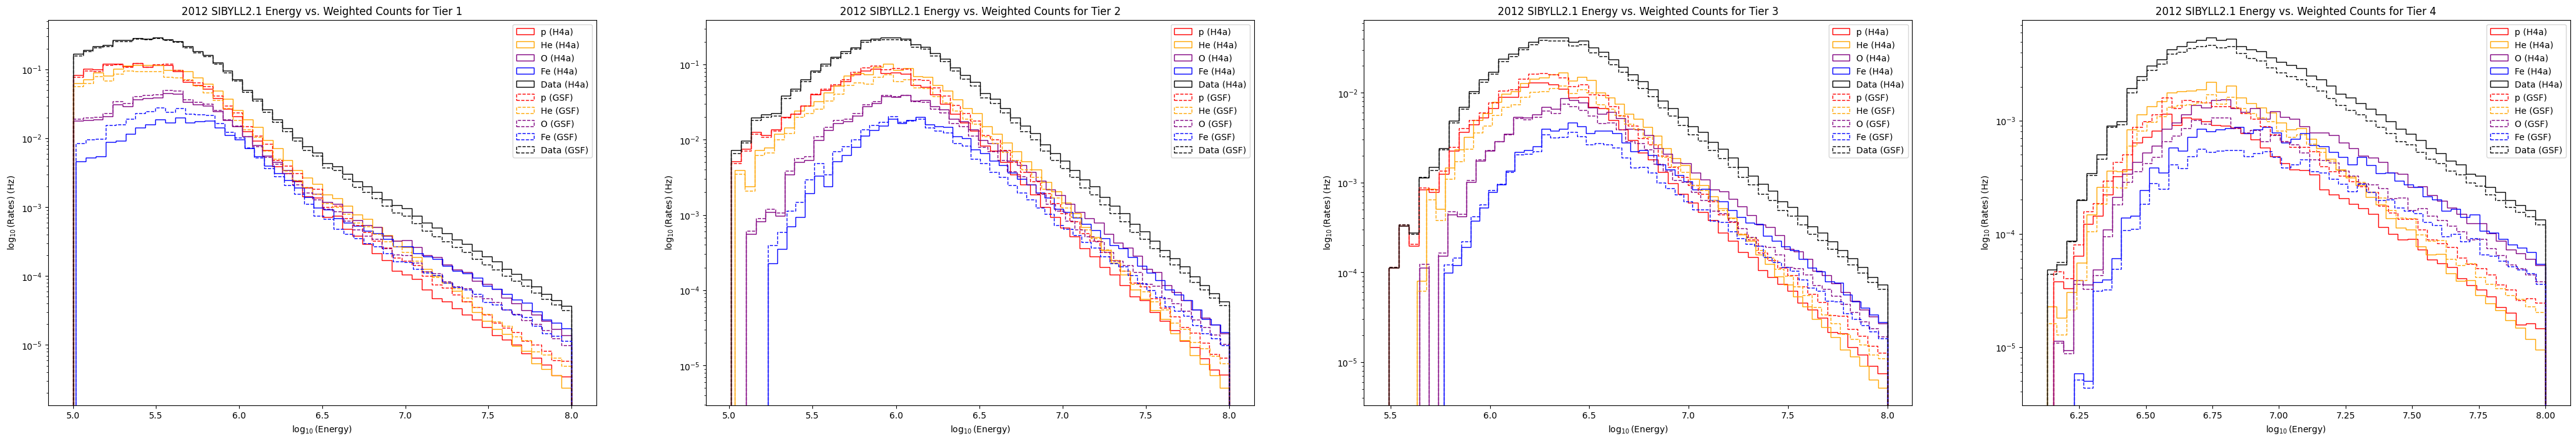

In [10]:
# Prepare the graphs
ncols = len(TIERS)
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    # Print Tier for table
    print(tier)
    print('--------------------------------------------------')
    
    for weight_name, weights in SIMS.items():
        # Print weights for table
        print(weight_name)

        for comp, comp_cut in CUTS.items():
            # Combine cuts
            combined_cut = np.logical_and(comp_cut, tier_cut)

            # Graph primary energy
            FLUX[comp][tier][weight_name], BINS[comp][tier][weight_name], patches1 = ax.hist(np.log10(energy[combined_cut]), weights=weights[combined_cut], bins=nbins, linestyle=LINESTYLE[weight_name], log=True, label=f'{LABEL[comp]} ({weight_name})', histtype='step', color=COLORS[comp])

            # Print median energy and its first sigma
            if comp=='proton' or comp=='iron' or comp=='true':
                print(f'    {comp}')
                print(f'        Median: {round(weighted_quantiles(energy[combined_cut] / 1000000, weights[combined_cut]), 2)} PeV')
                print(f'        68%: {round(weighted_percentile(energy[combined_cut] / 1000000, weights[combined_cut], 16), 2)}-{round(weighted_percentile(energy[combined_cut] / 1000000, Hweights[combined_cut], 84), 2)} PeV')
                print()

    # Label axes and add legend and title
    ax.set_xlabel('$\log_{{10}}$(Energy)')
    ax.set_ylabel('$\log_{{10}}$(Rates) (Hz)')
    ax.set_title(f'{year} {simulation} Energy vs. Weighted Counts for {tier}')
    ax.legend()

## Mean Atomic Charge

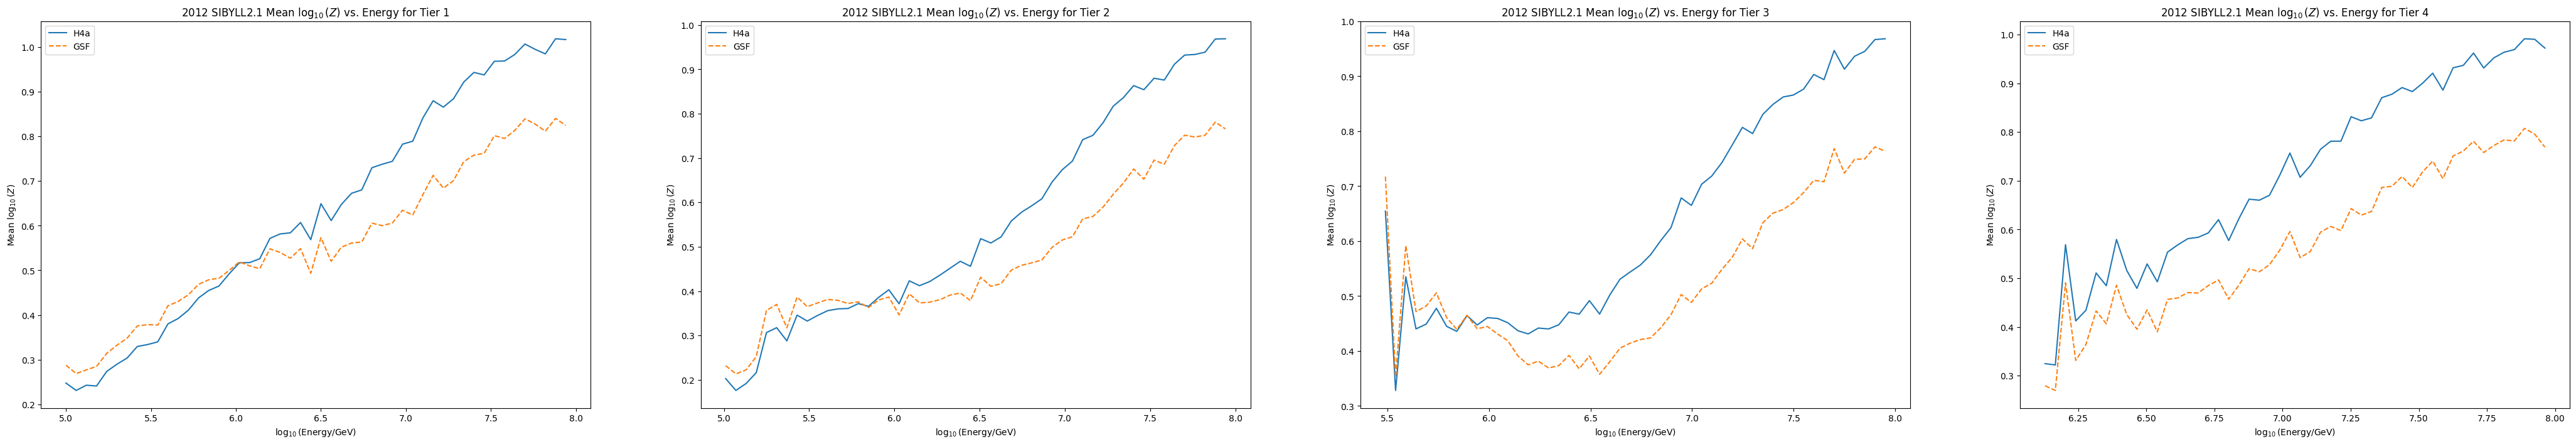

In [11]:
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, ax in zip(TIERS, axs):    
    for weight_name in SIMS:
        for comp in CUTS:
            if not comp=='true':
                # Sum flux at for each comp, Tier and weight times the number of protons for the comp
                TOTALS['numerator'][tier][weight_name] += FLUX[comp][tier][weight_name] * np.log10(Z[comp])

                # Sum flux at for each comp, Tier and weight
                TOTALS['denominator'][tier][weight_name] += FLUX[comp][tier][weight_name]

        # Calculate <Z>
        meanZ = TOTALS['numerator'][tier][weight_name] / TOTALS['denominator'][tier][weight_name]

        # Plot <Z> vs. energy
        ax.plot(BINS['true'][tier][weight_name][:-1], meanZ, label=weight_name, linestyle=LINESTYLE[weight_name])

    ax.set_xlabel('$\log_{{10}}$(Energy/GeV)')
    ax.set_ylabel('Mean $\log_{{10}}(Z)$')
    ax.set_title(f'{year} {simulation} Mean $\log_{{10}}(Z)$ vs. Energy for {tier}')

    ax.legend()

## Particle Fraction vs. Energy

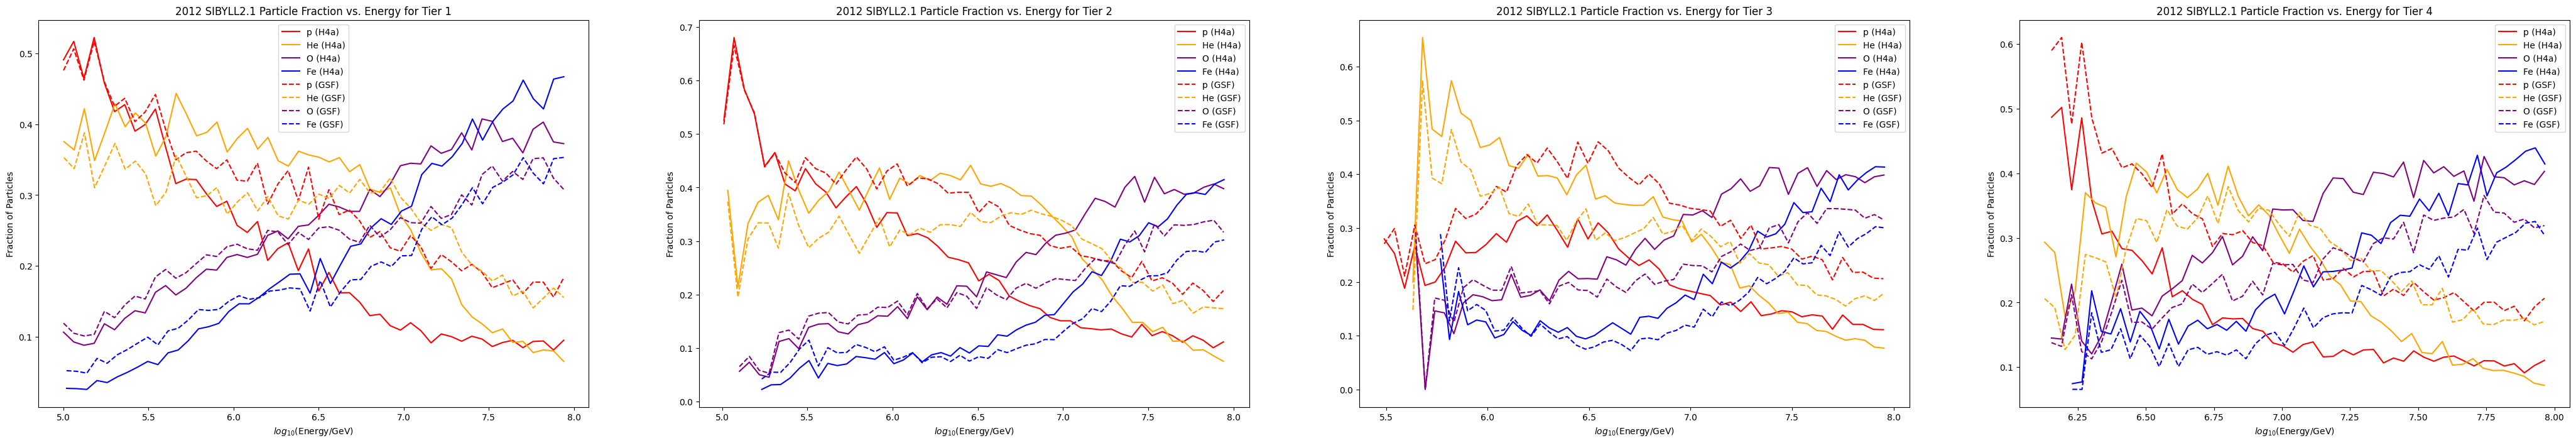

In [12]:
# Particle Fraction vs. Energy
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)

for tier, ax in zip(TIERS, axs):
    for weight_name in SIMS:
        for comp in CUTS:
            # Plot fractional composition
            if not comp=='true':
                ax.plot(BINS[comp][tier][weight_name][:-1], FLUX[comp][tier][weight_name] / TOTALS['denominator'][tier][weight_name],
                label=f'{LABEL[comp]} ({weight_name})', linestyle=LINESTYLE[weight_name], color=COLORS[comp])

    ax.set_xlabel('$log_{{10}}$(Energy/GeV)')
    ax.set_ylabel('Fraction of Particles')
    ax.set_title(f'{year} {simulation} Particle Fraction vs. Energy for {tier}')

    ax.legend()

## Table of percentage of particles, $\ln(A)$, and mean $\log_{10}$ of Rigidity

In [13]:
print(f'{year} {simulation}')
print()

for weight_name, weights in SIMS.items():
    # Print weight name for data table
    print(weight_name)
    print()

    for tier, tier_cut in TIERS.items():
        # Start ln_A at zero
        ln_A = 0

        for comp in CUTS:
            if not comp=='true':
                
                # Save the partial compositions to the table
                TABLE[weight_name][tier][f'{comp} part'] = round(np.mean(FLUX[comp][tier][weight_name]) / np.mean(TOTALS['denominator'][tier][weight_name]), 3)

                # Calculate the mean ln(A) with partial compositions
                ln_A += TABLE[weight_name][tier][f'{comp} part'] * np.log(A[comp])

        # Save ln(A) to the table
        TABLE[weight_name][tier]['ln(A)'] = round(ln_A, 3)
        
        # Calculate mean log E (Scaled to TeV), mean log Z, and finally mean log rigidity
        TABLE[weight_name][tier]['<log(E)>'] = round(np.average(np.log10(energy)[tier_cut] - 3, weights=weights[tier_cut]), 3)
        TABLE[weight_name][tier]['<log(Z)>'] = round(np.mean(TOTALS['numerator'][tier][weight_name]) / np.mean(TOTALS['denominator'][tier][weight_name]), 3)
        TABLE[weight_name][tier]['<log(R)>'] = TABLE[weight_name][tier]['<log(E)>'] - TABLE[weight_name][tier]['<log(Z)>']

    # Print out the table for that weight
    print(DataFrame(TABLE[weight_name]))
    print()

2012 SIBYLL2.1

H4a

             Tier 1  Tier 2  Tier 3  Tier 4
proton part   0.399   0.351   0.280   0.181
helium part   0.393   0.400   0.391   0.328
oxygen part   0.142   0.164   0.209   0.288
iron part     0.066   0.085   0.119   0.203
ln(A)         1.207   1.354   1.602   2.071
<log(R)>      2.161   2.581   2.922   3.240
<log(E)>      2.502   2.970   3.397   3.886
<log(Z)>      0.341   0.389   0.475   0.646

GSF

             Tier 1  Tier 2  Tier 3  Tier 4
proton part   0.418   0.423   0.395   0.312
helium part   0.329   0.318   0.315   0.312
oxygen part   0.159   0.170   0.190   0.227
iron part     0.093   0.089   0.100   0.149
ln(A)         1.274   1.273   1.369   1.664
<log(R)>      2.125   2.588   2.976   3.361
<log(E)>      2.500   2.963   3.384   3.871
<log(Z)>      0.375   0.375   0.408   0.510



Tier 1

    H4a
                Mean: 1.0952243936238995
                Median: 1.0379269832432503

    GSF
                Mean: 2.190448787247799
                Median: 2.0758539664865006

Tier 2

    H4a
                Mean: 3.217988935791526
                Median: 3.097872168151496

    GSF
                Mean: 4.24552908433525
                Median: 4.574113352652638

Tier 3

    H4a
                Mean: 4.462171288172791
                Median: 4.574478238826444

    GSF
                Mean: 4.67881349201033
                Median: 4.762034153763036

Tier 4

    H4a
                Mean: 4.7178465336382285
                Median: 4.762034153763036

    GSF
                Mean: 4.756879575266128
                Median: 4.7923890467830645



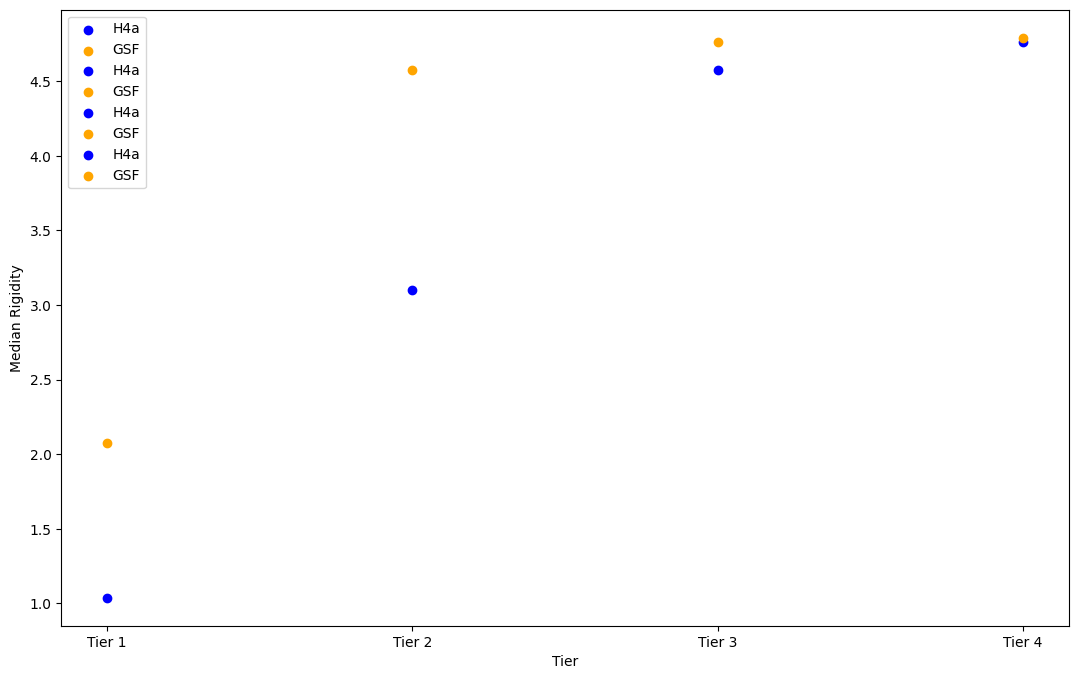

In [33]:
# Alternate median(log(R)) caluclation
COLS = {
    'H4a': 'blue',
    'GSF': 'orange'
}
fig, axs = plt.subplots(figsize=(13, 8), ncols=1)

summation = np.zeros(len(energy))
for tier, tier_cut in zip(TIERS.keys(), TIERS.values()):
    print(tier)
    print()
    #summation = np.zeros(len(energy))
    for weight_name, weihgts in SIMS.items():
        print(f'    {weight_name}')

        for comp, comp_cut in CUTS.items():
            if not comp == 'true':
                combined_cut = np.logical_and(comp_cut, tier_cut)
                rigidity = combined_cut * (np.log10(energy) - 3 - np.log10(Z[comp]))

                summation += rigidity
                proton_cut = CUTS['proton']
        
        print(f'                Mean: {np.average(summation, weights=weights)}')
        print(f'                Median: {weighted_quantiles(summation, weights=weights)}')
        print()
        axs.scatter(tier, weighted_quantiles(summation, weights=weights), label=weight_name, color=COLS[weight_name])
axs.set_xlabel('Tier')
axs.set_ylabel('Median Rigidity')
axs.legend()

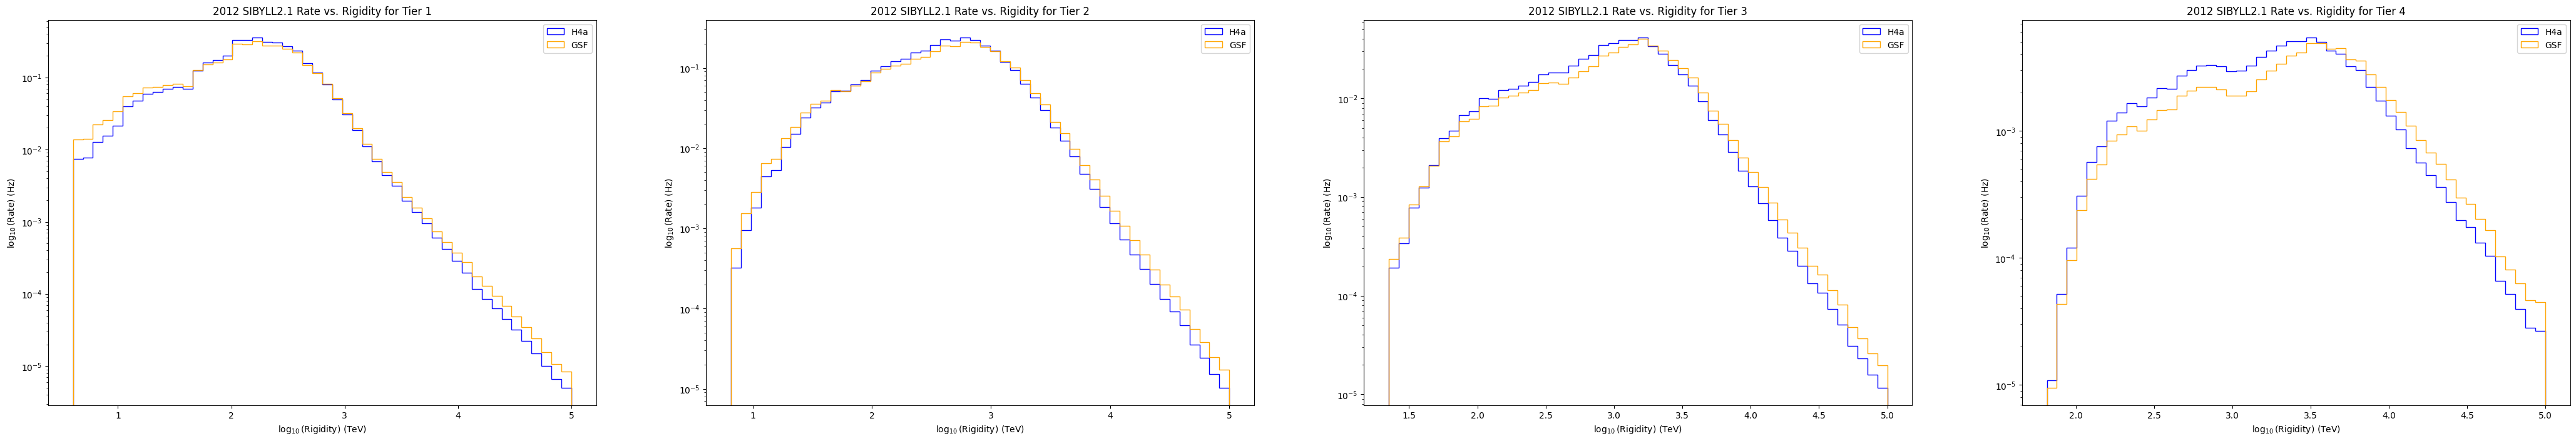

In [63]:
# Rate vs Rigidity
fig, axs = plt.subplots(figsize=(13 * ncols, 8), ncols=ncols)
rigidity = np.log10(energy) - 3
for comp, comp_cut in CUTS.items():
    if not comp == 'true':
        rigidity[comp_cut] -= np.log10(Z[comp])

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    total_rigidity = np.zeros(len(energy[tier_cut]))
    for weight_name, weights in SIMS.items():
        # Graph rate vs. rigidity
        ax.hist(rigidity[tier_cut], weights=weights[tier_cut], bins=nbins, color=COLS[weight_name], log=True, label=weight_name, histtype='step')
    
    ax.set_xlabel('$\log_{{10}}$(Rigidity) (TeV)')
    ax.set_ylabel('$\log_{{10}}$(Rate) (Hz)')
    ax.set_title(f'{year} {simulation} Rate vs. Rigidity for {tier}')
    ax.legend()

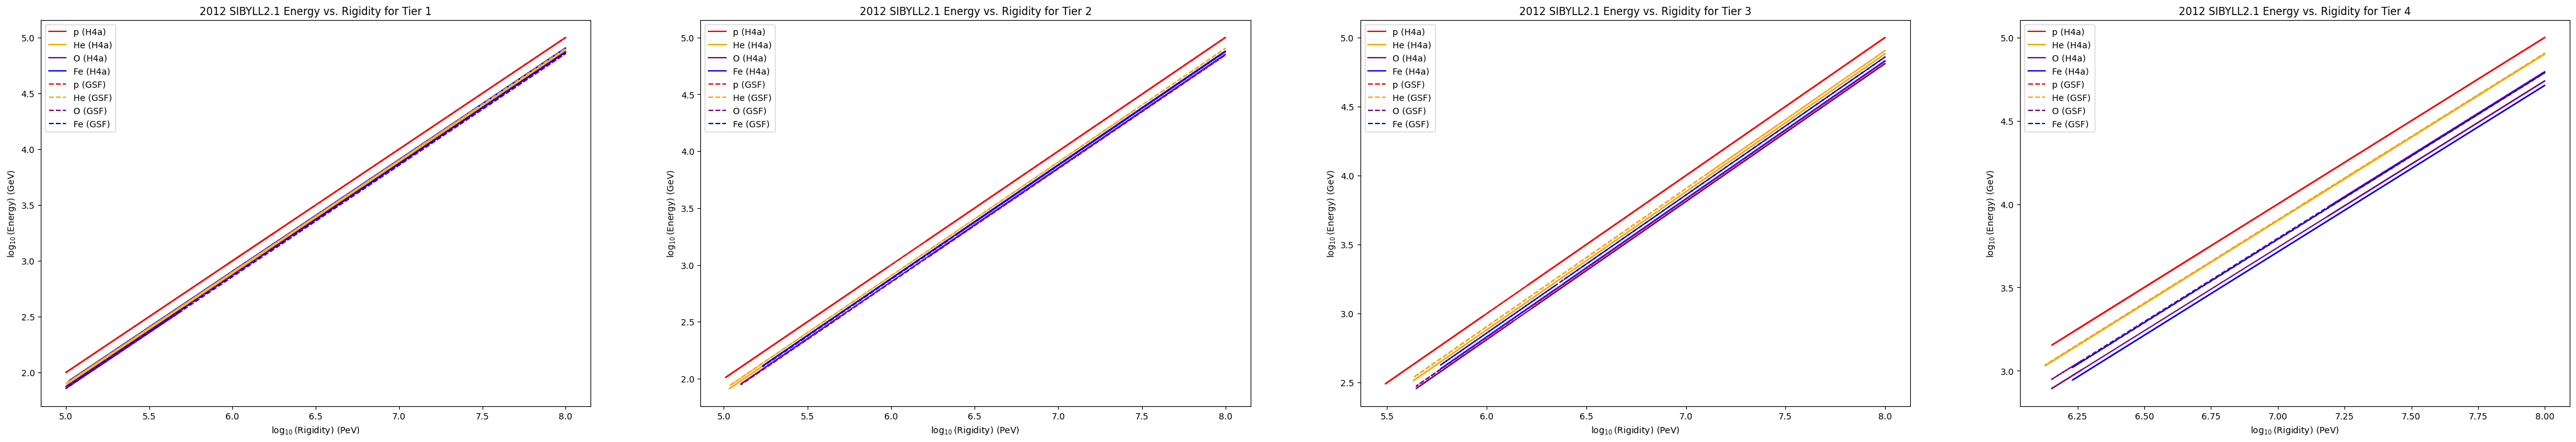

In [16]:
fig, axs = plt.subplots(figsize = (13 * ncols, 8), ncols=ncols)

for tier, tier_cut, ax in zip(TIERS.keys(), TIERS.values(), axs):
    for weight_name, weights in SIMS.items():
        for comp, comp_cut in CUTS.items():
            if not comp=='true':
                combined_cut = np.logical_and(comp_cut, tier_cut)
                rigidity = np.log10(energy[combined_cut]) - 3 - np.mean(FLUX[comp][tier][weight_name] * np.log10(Z[comp])) / np.mean(TOTALS['denominator'][tier][weight_name])
                # Graph rate vs. rigidity
                ax.plot(np.log10(energy[combined_cut]), rigidity, linestyle=LINESTYLE[weight_name],
                        label=f'{LABEL[comp]} ({weight_name})', color=COLORS[comp])
    
    ax.set_xlabel('$\log_{{10}}$(Rigidity) (PeV)')
    ax.set_ylabel('$\log_{{10}}$(Energy) (GeV)')
    ax.set_title(f'{year} {simulation} Energy vs. Rigidity for {tier}')
    ax.legend()